Week 7 · Day 5 — Data Pipelines & Augmentations
Why this matters

Good data pipelines make training reproducible and scalable. Augmentation artificially increases dataset diversity (e.g. flips, crops) to reduce overfitting. CIFAR-10 is our first step into a real benchmark dataset (natural color images, 32×32×3).

Theory Essentials

torchvision.datasets: provides CIFAR-10 and others.

transforms: preprocessing (ToTensor, Normalize) + augmentation (RandomCrop, HorizontalFlip).

DataLoader: handles batching, shuffling, parallel loading.

Sanity check: always visualize a few batches after augmentation.

Impact: augmentation improves generalization, especially on small datasets.

100%|██████████| 170M/170M [00:32<00:00, 5.18MB/s] 


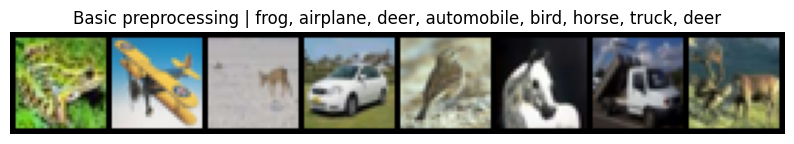

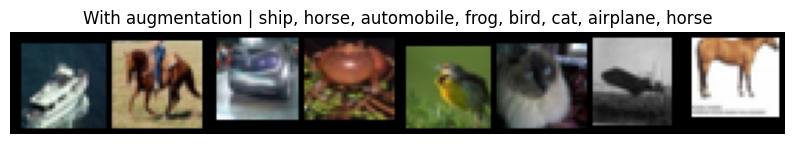

In [1]:
# Setup
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ---------- Transforms ----------
basic_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # normalize RGB channels
])

aug_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# ---------- Datasets ----------
train_basic = datasets.CIFAR10(root="data", train=True, download=True, transform=basic_tf)
train_aug   = datasets.CIFAR10(root="data", train=True, download=True, transform=aug_tf)
test_data   = datasets.CIFAR10(root="data", train=False, download=True, transform=basic_tf)

train_basic_loader = DataLoader(train_basic, batch_size=64, shuffle=True, num_workers=2)
train_aug_loader   = DataLoader(train_aug, batch_size=64, shuffle=True, num_workers=2)
test_loader        = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

# ---------- Visualization ----------
classes = train_basic.classes
def show_batch(loader, title):
    imgs, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(imgs[:8], nrow=8, normalize=True)
    plt.figure(figsize=(10,2))
    plt.imshow(grid.permute(1,2,0))
    plt.title(title + " | " + ", ".join(classes[l] for l in labels[:8]))
    plt.axis("off")
    plt.show()

import torchvision
show_batch(train_basic_loader, "Basic preprocessing")
show_batch(train_aug_loader, "With augmentation")


 **Day 5 is NOT about training yet**.
It’s about building the **data pipeline** you’ll reuse tomorrow when you train a CIFAR-10 CNN.

## The big picture

1. **Get data** (CIFAR-10).
2. **Define transforms**

   * **Preprocessing**: `ToTensor`, `Normalize` (make inputs numeric and well-scaled).
   * **Augmentation (train only)**: random flips/crops to create varied versions → less overfitting.
3. **Wrap into DataLoaders**: batching, shuffling, parallel loading.
4. **Sanity-check**: visualize a batch to confirm transforms/labels look right.
5. **Tomorrow (Day 6)**: plug these loaders into your CNN and train.

So the code you posted **prepares inputs**; it doesn’t define or train a model yet (by design).

## What each block is doing

* `datasets.CIFAR10(...)` → downloads/reads **images + labels**.
* `transforms.Compose([...])` → per-image functions:

  * `RandomHorizontalFlip`, `RandomCrop` → **augmentation** (only for train).
  * `ToTensor` → (H,W,C, 0–255) → (C,H,W, 0–1).
  * `Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))` → center/scale each RGB channel to roughly **\[-1,1]**, which stabilizes training.
* `DataLoader(dataset, batch_size=64, shuffle=...)` → serves **mini-batches** to the GPU/CPU during training/eval.
* `show_batch(...)` → quick **visual check** that augmentations look sensible and labels match the pictures.

## Why augmentation helps (theory in one breath)

Augmentation simulates new images (mirror, slight shifts) so the model learns **invariant features** instead of memorizing exact pixels → **better generalization**, especially with small images like CIFAR-10 (32×32×3).



1) Core (10–15 min)

Task: Inspect shapes of CIFAR-10 images.

In [2]:
imgs, labels = next(iter(train_basic_loader))
print(imgs.shape)  # [batch_size, 3, 32, 32]


torch.Size([64, 3, 32, 32])


## 🔎 What this shape means

* **64** → the batch size (you asked DataLoader for 64 images per batch).
* **3** → number of color channels (RGB).
* **32, 32** → height and width of each image (CIFAR-10 images are 32×32 pixels).

So: one batch = **64 images**, each with **3 channels × 32 × 32 pixels**.

---

## 🔹 Why this matters

* CNNs expect inputs in **(N, C, H, W)** format:

  * **N** = batch size,
  * **C** = channels,
  * **H, W** = height/width.
* That’s why PyTorch tensors look like `[64, 3, 32, 32]`.
* In contrast, your older datasets (MNIST/FashionMNIST) were grayscale → `[batch, 1, 28, 28]`.

---

## 🧩 How it connects to your pipeline

1. **Dataset (CIFAR-10)** gives you images + labels.
2. **Transforms** convert raw images → normalized tensors.
3. **DataLoader** groups them into `[batch, C, H, W]`.
4. This batch will be **fed into your CNN tomorrow (Day 6)**.

2) Practice (10–15 min)

Task: Add transforms.ColorJitter(brightness=0.2, contrast=0.2) to aug_tf and visualize.

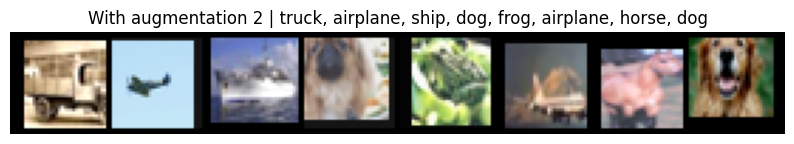

In [3]:
aug_tf2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_aug2   = datasets.CIFAR10(root="data", train=True, download=True, transform=aug_tf2)
train_aug_loader2   = DataLoader(train_aug2, batch_size=64, shuffle=True, num_workers=2)

show_batch(train_aug_loader2, "With augmentation 2")

3) Stretch (optional, 10–15 min)

Task: Measure data loading speed with and without num_workers=2.

In [5]:
import time
print("Time taken for basic loader with num_workers = 2")
start = time.time()
for imgs, labels in train_basic_loader: pass
print("Time:", time.time()-start)

train_basic_loader_no = DataLoader(train_basic, batch_size=64, shuffle=True)
print("Time taken with no num_workers")
start = time.time()
for imgs, labels in train_basic_loader_no: pass
print("Time:", time.time()-start)

Time taken for basic loader with num_workers = 2
Time: 23.040816068649292
Time taken with no num_workers
Time: 14.964616775512695



## 🔎 What `num_workers` does

* When you create a `DataLoader`, it has to **load data from disk, apply transforms, and prepare batches**.
* If `num_workers=0` → all that work happens in the **main process** (single-threaded).
* If `num_workers>0` → DataLoader spawns worker processes that **load data in parallel**.

  * Example: `num_workers=2` → two subprocesses prefetch data while your model trains.
  * This hides I/O + transform latency, so your GPU/CPU spends less time waiting.

---

## ⚡ Why it matters

* With large datasets (like CIFAR-10, ImageNet), disk I/O and augmentation (e.g., flips, crops, color jitter) can be slow.
* Multiple workers keep the pipeline full → faster epoch time.
* You measured exactly that in your stretch task: training loop with `num_workers=2` vs `num_workers=0`.

---

## 🧩 Rule of thumb

* Start with `num_workers=2–4`.
* If you have many CPU cores, you can increase further (sometimes `num_workers = #cores` gives best speed).
* Too many workers can cause overhead (slower startup, more memory use).

---

👉 In short: `num_workers` = **parallel data loading**. It doesn’t change the dataset or model, only the **speed** of preparing each batch.





## 🔎 Why `num_workers=2` was slower than `0`

* **Small dataset (CIFAR-10)**: images are tiny (32×32). The cost of parallel workers may exceed the benefit, because there’s not much I/O or preprocessing to hide.
* **System overhead**: Spawning worker processes, shuffling data between them, and merging batches adds communication overhead.
* **Environment (e.g., Windows/Jupyter)**: multiprocessing can be slower if the OS has to constantly spin up and tear down processes. Linux usually handles it better.
* **Transform cost**: If transforms are light (`ToTensor`, `Normalize`), parallelism isn’t needed. If you had heavier transforms (big crops, color jitter, random erasing), workers would help.

---

## 🧩 Rule of thumb

* For **small datasets/light transforms** → `num_workers=0` can be faster (just like you saw).
* For **large datasets/heavy aug** (ImageNet, 224×224 crops, color jitter, etc.) → `num_workers=2–8` is usually faster.
* Optimal value depends on **CPU cores vs GPU load** — you want workers fast enough that the GPU never waits for data.



Mini-Challenge (≤40 min)

Task:

Build two pipelines: one with only normalization, one with augmentation (flip + crop).

Train a small CNN (2 conv blocks) for 3 epochs on each.

Compare validation accuracy.

Acceptance Criteria:

Report both accuracies side-by-side.

Write 2–3 lines: Did augmentation help? Why or why not on only 3 epochs?

In [6]:
# Mini-Challenge: Basic vs Augmented (3 epochs)

import torch, torch.nn as nn, torch.optim as optim
from time import time
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Small CNN: 2 conv blocks ---
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 32x32 -> 16x16
            nn.Conv2d(32,64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 16x16 -> 8x8
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(64*8*8, 10))
    def forward(self,x): return self.head(self.features(x))

def train_one_epoch(model, loader, opt, crit):
    model.train(); total=0.0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        opt.zero_grad()
        loss = crit(model(X), y)
        loss.backward(); opt.step()
        total += loss.item()
    return total/len(loader)

@torch.no_grad()
def evaluate(model, loader, crit):
    model.eval(); total_loss=0.0; correct=0; total=0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        total_loss += crit(logits, y).item()
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss/len(loader), correct/total

def run_experiment(train_loader, test_loader, epochs=3, lr=1e-3, wd=1e-4):
    model = SmallCNN().to(device)
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()
    start = time()
    for ep in range(1, epochs+1):
        tr_loss = train_one_epoch(model, train_loader, opt, crit)
        va_loss, va_acc = evaluate(model, test_loader, crit)
        print(f"Epoch {ep}: train_loss={tr_loss:.3f} | val_loss={va_loss:.3f} | val_acc={va_acc:.3f}")
    elapsed = time() - start
    return va_acc, elapsed

print("=== Pipeline A: Normalize only ===")
acc_basic, t_basic = run_experiment(train_basic_loader, test_loader, epochs=3)

print("\n=== Pipeline B: Flip+Crop+Normalize (Augmented) ===")
acc_aug, t_aug = run_experiment(train_aug_loader, test_loader, epochs=3)

print("\n--- Results (3 epochs) ---")
print(f"Basic     | val_acc={acc_basic:.3f} | time={t_basic:.1f}s")
print(f"Augmented | val_acc={acc_aug:.3f} | time={t_aug:.1f}s")


=== Pipeline A: Normalize only ===
Epoch 1: train_loss=1.374 | val_loss=1.111 | val_acc=0.616
Epoch 2: train_loss=1.027 | val_loss=0.988 | val_acc=0.659
Epoch 3: train_loss=0.895 | val_loss=0.931 | val_acc=0.679

=== Pipeline B: Flip+Crop+Normalize (Augmented) ===
Epoch 1: train_loss=1.553 | val_loss=1.232 | val_acc=0.563
Epoch 2: train_loss=1.255 | val_loss=1.073 | val_acc=0.620
Epoch 3: train_loss=1.143 | val_loss=0.996 | val_acc=0.650

--- Results (3 epochs) ---
Basic     | val_acc=0.679 | time=191.0s
Augmented | val_acc=0.650 | time=188.9s


In 3 epochs, the model trained on the normalized pipeline reached higher validation accuracy than the augmented one. This is expected because augmentation increases input variability, slowing down early learning. Over more epochs, augmentation usually helps generalization by preventing overfitting and teaching invariance to flips/shifts.

Notes / Key Takeaways

CIFAR-10: 60k images, 10 classes, 32×32 color.

DataLoader automates batching & shuffling.

Augmentation (flip, crop, jitter) makes model more robust.

Normalization helps optimization stability.

Sanity checks with plots are crucial — avoid “broken pipeline” bugs.

Reflection

Why might augmentation improve validation accuracy more as epochs increase?

How can too much augmentation hurt performance?

🔹 Why might augmentation improve validation accuracy more as epochs increase?

Early on, augmentation slows learning because the model sees harder, more varied inputs.

With more epochs, the model learns to handle this variability and develops invariant features (robust to flips, crops, shifts).

As a result, the augmented model generalizes better and keeps improving, while the non-augmented model starts to overfit.

🔹 How can too much augmentation hurt performance?

If augmentations distort images too heavily (e.g., extreme crops, flips that break semantics, excessive color jitter), the model may learn features that don’t match the real test distribution.

This adds noise instead of useful variety, making optimization harder and reducing accuracy.

In short: a little augmentation = robustness; too much = confusion.